<a href="https://colab.research.google.com/github/supun-ganegoda/Denoiser---GAN/blob/main/Signal_Denoiser_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [48]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import signal
import os
import time
from scipy.io import loadmat, savemat

Set random seed for reproducibility

In [49]:
tf.random.set_seed(42)
np.random.seed(42)

Data preperation function

Generating a signal by extracting the dominent frequency in inputted noisy signal

In [50]:
'''
def load_and_process_data(mat_path, segment_length=1024, test_size=0.2):
    """Load and process data ensuring proper (noisy, clean) pairs"""
    mat_data = loadmat(mat_path)
    noisy_signal = mat_data['X_'].squeeze()

    # Create clean reference signal
    fs = 10000
    duration = len(noisy_signal)/fs
    t = np.linspace(0, duration, len(noisy_signal), endpoint=False)

    # Find dominant frequency
    f, Pxx = signal.periodogram(noisy_signal, fs)
    mask = (f >= 1000) & (f <= 4000)
    dominant_freq = f[mask][np.argmax(Pxx[mask])]
    clean_signal = np.sin(2 * np.pi * dominant_freq * t)

    # Create segments
    def create_segments(signal):
        num_segments = max(1, (len(signal) - segment_length) // (segment_length // 2) + 1)
        segments = np.zeros((num_segments, segment_length))
        for i in range(num_segments):
            start = i * (segment_length // 2)
            end = start + segment_length
            segments[i] = signal[start:end]
        return segments

    noisy_segments = create_segments(noisy_signal)
    clean_segments = create_segments(clean_signal)

    # Normalize and return as pairs
    noisy_segments = (noisy_segments - np.mean(noisy_segments, axis=1, keepdims=True)) / np.std(noisy_segments, axis=1, keepdims=True)
    clean_segments = (clean_segments - np.mean(clean_segments, axis=1, keepdims=True)) / np.std(clean_segments, axis=1, keepdims=True)

    noisy_segments = noisy_segments.astype(np.float32)
    clean_segments = clean_segments.astype(np.float32)

    # Split into train and test
    return train_test_split(noisy_segments, clean_segments, test_size=test_size, random_state=42)
    '''

'\ndef load_and_process_data(mat_path, segment_length=1024, test_size=0.2):\n    """Load and process data ensuring proper (noisy, clean) pairs"""\n    mat_data = loadmat(mat_path)\n    noisy_signal = mat_data[\'X_\'].squeeze()\n\n    # Create clean reference signal\n    fs = 10000\n    duration = len(noisy_signal)/fs\n    t = np.linspace(0, duration, len(noisy_signal), endpoint=False)\n\n    # Find dominant frequency\n    f, Pxx = signal.periodogram(noisy_signal, fs)\n    mask = (f >= 1000) & (f <= 4000)\n    dominant_freq = f[mask][np.argmax(Pxx[mask])]\n    clean_signal = np.sin(2 * np.pi * dominant_freq * t)\n\n    # Create segments\n    def create_segments(signal):\n        num_segments = max(1, (len(signal) - segment_length) // (segment_length // 2) + 1)\n        segments = np.zeros((num_segments, segment_length))\n        for i in range(num_segments):\n            start = i * (segment_length // 2)\n            end = start + segment_length\n            segments[i] = signal[start:e

Adopt a reference signal by an inputted signal

In [51]:
def load_and_process_data(mat_path, reference_path, segment_length=1024, test_size=0.2):
    """Load and process data ensuring proper (noisy, clean) pairs using reference signal from a .mat file"""
    mat_data = loadmat(mat_path)
    noisy_signal = mat_data['X_'].squeeze()

    # Load clean reference signal from the reference .mat file
    ref_data = loadmat(reference_path)
    clean_signal = ref_data['X_'].squeeze()

    # Ensure the clean and noisy signals are the same length
    min_len = min(len(noisy_signal), len(clean_signal))
    noisy_signal = noisy_signal[:min_len]
    clean_signal = clean_signal[:min_len]

    # Create segments
    def create_segments(signal):
        num_segments = max(1, (len(signal) - segment_length) // (segment_length // 2) + 1)
        segments = np.zeros((num_segments, segment_length))
        for i in range(num_segments):
            start = i * (segment_length // 2)
            end = start + segment_length
            segments[i] = signal[start:end]
        return segments

    noisy_segments = create_segments(noisy_signal)
    clean_segments = create_segments(clean_signal)

    # Normalize and return as pairs
    noisy_segments = (noisy_segments - np.mean(noisy_segments, axis=1, keepdims=True)) / np.std(noisy_segments, axis=1, keepdims=True)
    clean_segments = (clean_segments - np.mean(clean_segments, axis=1, keepdims=True)) / np.std(clean_segments, axis=1, keepdims=True)

    noisy_segments = noisy_segments.astype(np.float32)
    clean_segments = clean_segments.astype(np.float32)

    # Split into train and test
    return train_test_split(noisy_segments, clean_segments, test_size=test_size, random_state=42)

# Generator Model

In [52]:
class InstanceNormalization(layers.Layer):
    """Instance normalization layer (Copy from TensorFlow Addons)."""
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [53]:
def build_generator(input_shape=(1024, 1)):
    inputs = tf.keras.Input(shape=input_shape, dtype=tf.float32)

    # Initial downsampling
    x = layers.Conv1D(64, 25, strides=4, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Residual blocks
    def residual_block(x):
        shortcut = x
        x = layers.Conv1D(64, 9, padding='same')(x)
        x = InstanceNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.Conv1D(64, 9, padding='same')(x)
        x = InstanceNormalization()(x)
        return layers.Add()([shortcut, x])

    for _ in range(5):
        x = residual_block(x)

    # Upsampling
    x = layers.Conv1DTranspose(1, 25, strides=4, padding='same')(x)
    x = layers.Activation('tanh')(x)

    return models.Model(inputs, x, name='Generator')

# Descriminator Model

In [54]:
def build_discriminator(input_shape=(1024, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv1D(64, 15, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv1D(128, 15, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv1D(256, 15, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv1D(512, 15, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, x, name='Discriminator')

# GAN Model

In [55]:
class SignalDenoisingGAN(tf.keras.Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def call(self, inputs):
        """Forward pass of the GAN - generates denoised signals"""
        return self.generator(inputs)

    def compile(self, g_optimizer, d_optimizer, g_loss_fn, d_loss_fn, **kwargs):
        super().compile(loss=lambda y_true, y_pred: tf.constant(0.0), **kwargs)
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.loss = tf.keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric, self.loss]

    def train_step(self, data):
        # Unpack the data - now handling both cases where data is (noisy, clean) or just noisy
        if isinstance(data, (list, tuple)) and len(data) == 2:
            noisy_signals, clean_signals = data
        else:
            noisy_signals = data
            # Generate clean signals from noisy ones (fallback)
            clean_signals = noisy_signals  # This should be replaced with your actual clean signal generation

        batch_size = tf.shape(noisy_signals)[0]

        # Train discriminator
        with tf.GradientTape() as d_tape:
            generated_signals = self.generator(noisy_signals, training=True)
            real_output = self.discriminator(clean_signals, training=True)
            fake_output = self.discriminator(generated_signals, training=True)
            d_loss = self.d_loss_fn(real_output, fake_output)

        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Train generator
        with tf.GradientTape() as g_tape:
            generated_signals = self.generator(noisy_signals, training=True)
            fake_output = self.discriminator(generated_signals, training=True)
            g_loss = self.g_loss_fn(fake_output, generated_signals, clean_signals)

        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        # Update metrics
        self.g_loss_metric.update_state(g_loss)
        self.d_loss_metric.update_state(d_loss)
        self.loss.update_state(g_loss + d_loss)  # Track combined loss

        return {
            "g_loss": self.g_loss_metric.result(),
            "d_loss": self.d_loss_metric.result(),
            "loss": self.loss.result()  # Required by Keras
        }

Loss function

In [56]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output, generated_signals, clean_signals):
    # Ensure consistent float32 dtype
    clean_signals = tf.cast(clean_signals, tf.float32)
    generated_signals = tf.cast(generated_signals, tf.float32)

    # Adversarial loss
    adversarial_loss = tf.keras.losses.binary_crossentropy(
        tf.ones_like(fake_output),
        fake_output
    )

    # L1 reconstruction loss
    l1_loss = tf.reduce_mean(tf.abs(clean_signals - generated_signals))

    return adversarial_loss + 100 * l1_loss  # Weighted combination

# Train and Evaluation

Plotting the results

In [57]:
def plot_training_results(history, gan, test_dataset):
    """Plot training metrics and sample denoising results"""
    plt.figure(figsize=(15, 10))

    # 1. Training History
    plt.subplot(2, 2, 1)
    plt.plot(history.history['g_loss'], label='Generator Loss')
    plt.plot(history.history['d_loss'], label='Discriminator Loss')
    if 'val_g_loss' in history.history:
        plt.plot(history.history['val_g_loss'], label='Val Generator Loss')
        plt.plot(history.history['val_d_loss'], label='Val Discriminator Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Get test samples
    test_sample = next(iter(test_dataset))
    test_noisy, test_clean = test_sample
    denoised = gan.generator.predict(test_noisy)

    # 3. Sample Comparison
    plt.subplot(2, 2, 2)
    sample_idx = 0  # Plot first sample in batch
    plt.plot(test_noisy[sample_idx, :, 0], label='Noisy', alpha=0.6)
    plt.plot(test_clean[sample_idx, :, 0], label='Clean', alpha=0.8)
    plt.plot(denoised[sample_idx, :, 0], label='Denoised')
    plt.title('Signal Comparison')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)

    # 4. Frequency Spectrum
    plt.subplot(2, 2, 3)
    fs = 10000  # Adjust based on your sampling rate
    f, Pxx_noisy = signal.periodogram(test_noisy[sample_idx, :, 0], fs)
    f, Pxx_clean = signal.periodogram(test_clean[sample_idx, :, 0], fs)
    f, Pxx_denoised = signal.periodogram(denoised[sample_idx, :, 0], fs)

    plt.semilogy(f, Pxx_noisy, label='Noisy')
    plt.semilogy(f, Pxx_clean, label='Clean')
    plt.semilogy(f, Pxx_denoised, label='Denoised')
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.xlim(0, 5000)  # Focus on 0-5kHz
    plt.legend()
    plt.grid(True)

    # 5. Error Analysis
    plt.subplot(2, 2, 4)
    error = np.abs(test_clean[sample_idx, :, 0] - denoised[sample_idx, :, 0])
    plt.plot(error, label='Denoising Error')
    plt.title(f'Denoising Error (MAE: {np.mean(error):.4f})')
    plt.xlabel('Samples')
    plt.ylabel('Absolute Error')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [58]:
def plot_signal_comparison(gan, test_dataset, num_samples=3):
    """
    Plot comparison between input noisy signals and output denoised signals
    Args:
        gan: Trained GAN model
        test_dataset: Test dataset containing noisy signals
        num_samples: Number of samples to display
    """
    # Get a batch of test data
    test_batch = next(iter(test_dataset))
    if isinstance(test_batch, tuple):
        noisy_signals, clean_signals = test_batch
    else:
        noisy_signals = test_batch
        clean_signals = None

    # Generate denoised signals
    denoised_signals = gan.generator.predict(noisy_signals)

    # Create figure
    plt.figure(figsize=(15, 3*num_samples))

    # Plot each sample
    for i in range(min(num_samples, noisy_signals.shape[0])):
        plt.subplot(num_samples, 1, i+1)

        # Plot input noisy signal
        plt.plot(noisy_signals[i, :, 0],
                label='Noisy Input',
                color='blue',
                alpha=0.6,
                linewidth=1)

        # Plot clean signal if available
        if clean_signals is not None:
            plt.plot(clean_signals[i, :, 0],
                    label='Clean Target',
                    color='green',
                    alpha=0.8,
                    linewidth=1)

        # Plot denoised output
        plt.plot(denoised_signals[i, :, 0],
                label='Denoised Output',
                color='red',
                linewidth=1.5)

        plt.title(f'Sample {i+1} - Signal Comparison')
        plt.ylabel('Amplitude')
        plt.xlabel('Time Samples')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

Save the output data as a mat file

In [59]:
def export_denoised_results(gan, test_dataset, output_mat_path="denoised_results.mat"):
    """
    Export input noisy signals and denoised outputs to a .mat file

    Args:
        gan: Trained GAN model
        test_dataset: Test dataset containing noisy signals
        output_mat_path: Path to save the .mat file
    """
    # Get test data
    test_batch = next(iter(test_dataset))
    if isinstance(test_batch, tuple):
        noisy_signals, clean_signals = test_batch
    else:
        noisy_signals = test_batch
        clean_signals = None

    # Generate denoised signals
    denoised_signals = gan.generator.predict(noisy_signals)

    # Prepare data dictionary for .mat export
    mat_dict = {}

    # For each sample in the batch
    for i in range(noisy_signals.shape[0]):
        # Add noisy signal
        mat_dict[f"Sample_{i+1}_Noisy"] = noisy_signals[i, :, 0].numpy().flatten()

        # Add clean signal if available
        if clean_signals is not None:
            mat_dict[f"Sample_{i+1}_Clean"] = clean_signals[i, :, 0].numpy().flatten()

        # Add denoised signal
        mat_dict[f"Sample_{i+1}_Denoised"] = denoised_signals[i, :, 0].flatten()

    # Save to .mat file
    savemat(output_mat_path, mat_dict)

    print(f"Successfully exported results to {output_mat_path}")
    return mat_dict

Train the model

In [60]:
def train_gan(mat_path, ref_mat_path, epochs=100, batch_size=32):
    # Load data
    train_noisy, test_noisy, train_clean, test_clean = load_and_process_data(mat_path, ref_mat_path)

    # Add channel dimension
    train_noisy = train_noisy[..., np.newaxis]
    train_clean = train_clean[..., np.newaxis]
    test_noisy = test_noisy[..., np.newaxis]
    test_clean = test_clean[..., np.newaxis]

    # Create tf.data.Dataset with proper batching
    train_dataset = tf.data.Dataset.from_tensor_slices((train_noisy, train_clean))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices((test_noisy, test_clean))
    test_dataset = test_dataset.batch(batch_size)

    # Build and compile models
    generator = build_generator()
    discriminator = build_discriminator()

    gan = SignalDenoisingGAN(generator, discriminator)
    gan.compile(
      g_optimizer=tf.keras.optimizers.Adam(0.0002, beta_1=0.5),
      d_optimizer=tf.keras.optimizers.Adam(0.0002, beta_1=0.5),
      g_loss_fn=generator_loss,
      d_loss_fn=discriminator_loss
    )


    # Train the model
    history = gan.fit(
        train_dataset,
        epochs=epochs,
        validation_data=test_dataset,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                filepath='gan_checkpoint.weights.h5',
                save_weights_only=True,
                monitor='val_g_loss',
                mode='min',
                save_best_only=True
            ),
            tf.keras.callbacks.TensorBoard(log_dir='./logs')
        ]
    )

    # Plot results (now with access to test_dataset)
    plot_training_results(history, gan, test_dataset)
    # Change the number of samples if you want to plot the whole signal
    plot_signal_comparison(gan, test_dataset, num_samples=4)

    # save the output data as a csv file
    export_denoised_results(gan, test_dataset)

    return gan, history

# Main Execution

In [61]:
# Mount Google Drive if using Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - d_loss: 2.2913 - g_loss: 108.6116 - loss: 110.9029 - val_d_loss: 0.0000e+00 - val_g_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - d_loss: 4.2151 - g_loss: 96.0686 - loss: 100.2837 - val_d_loss: 0.0000e+00 - val_g_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - d_loss: 2.9353 - g_loss: 93.7497 - loss: 96.6850 - val_d_loss: 0.0000e+00 - val_g_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - d_loss: 0.7418 - g_loss: 95.9856 - loss: 96.7274 - val_d_loss: 0.0000e+00 - val_g_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - d_loss: 0.9874 - g_loss: 88.9184 - loss: 89.9058 - val_d_loss: 0.0000e+00 - val_g_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 6/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - d_loss: 0.0823 - g_loss: 84.9131 - loss: 84.9953 - val_d_loss

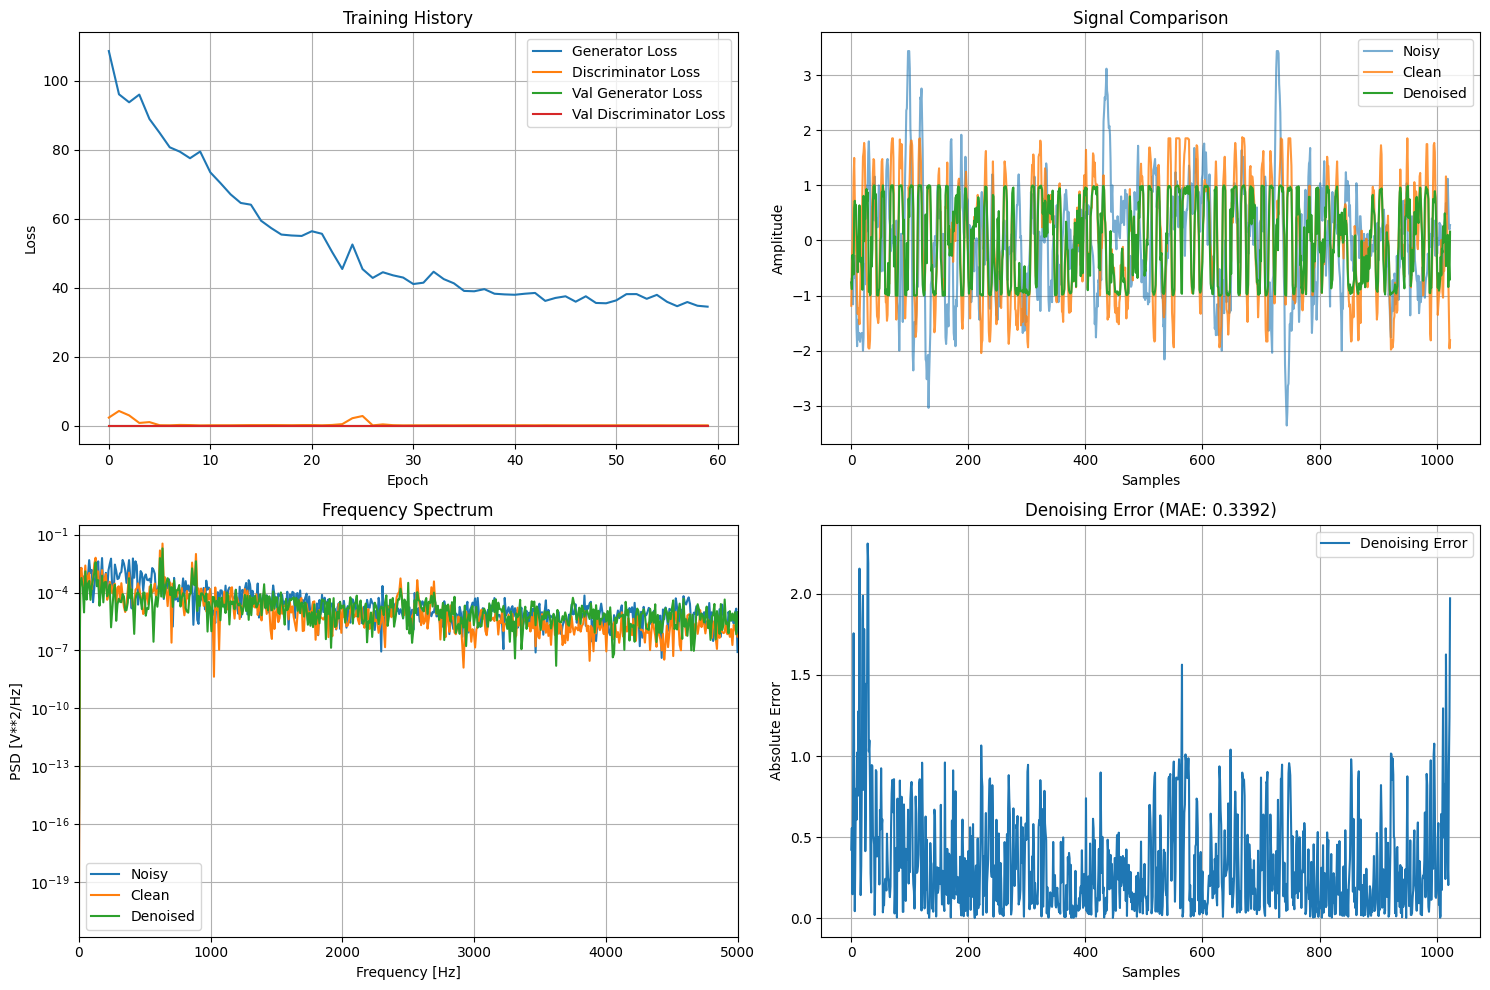

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


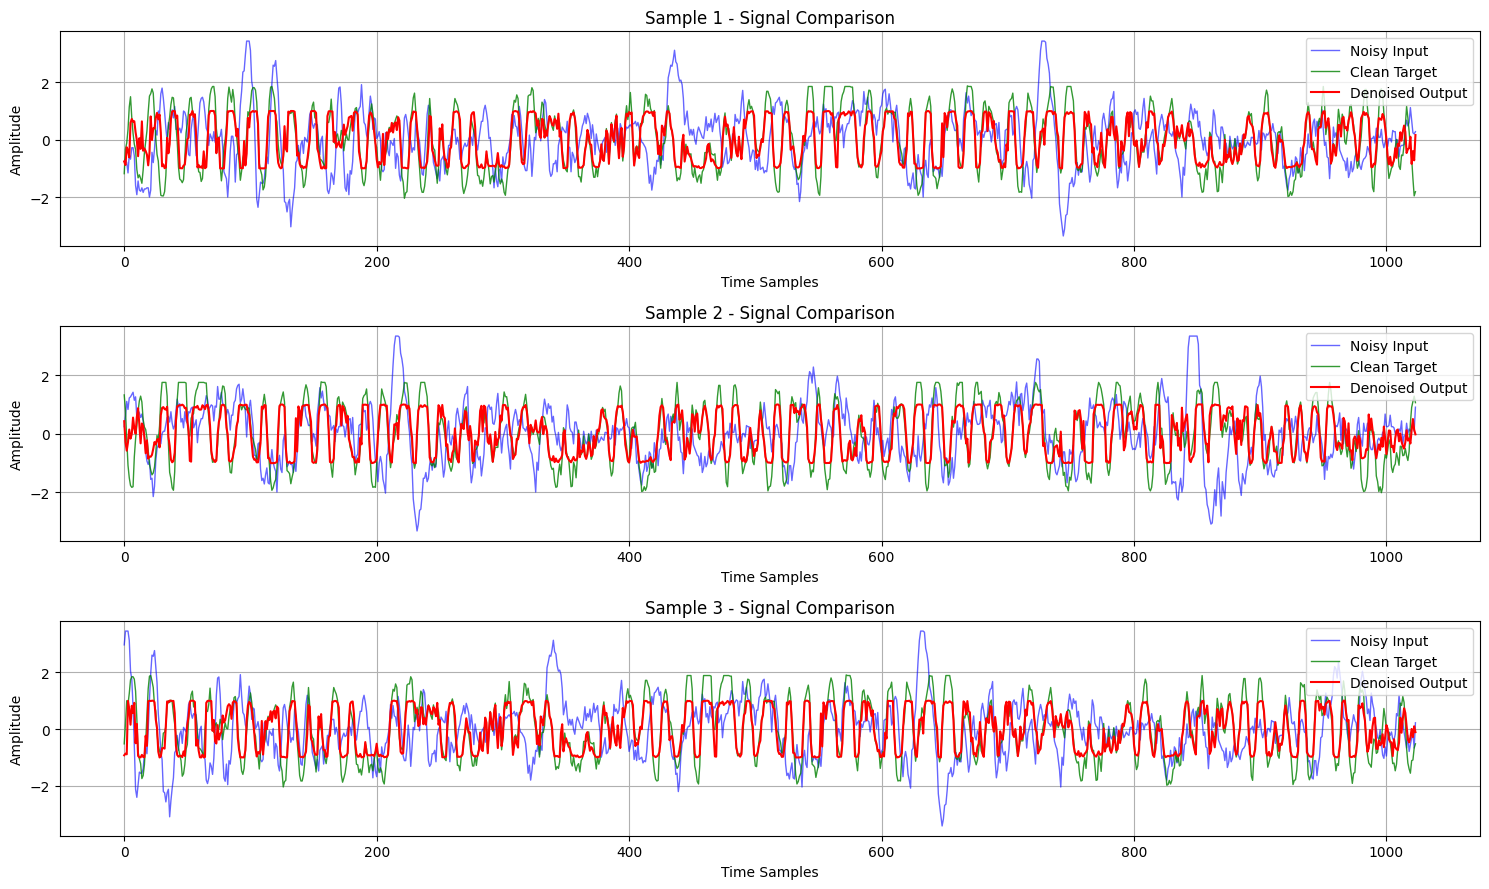

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Successfully exported results to denoised_results.mat


In [62]:
if __name__ == "__main__":
    # My drive path - Supun
    # /content/drive/MyDrive/Dataset/noisy_signal.mat

    # Path to your CSV file in Google Drive
    mat_path = '/content/drive/MyDrive/Dataset/noisy_signal.mat'
    ref_mat_path = '/content/drive/MyDrive/Dataset/ref_signal.mat'

    # Train the GAN
    gan, history = train_gan(mat_path, ref_mat_path, epochs=100, batch_size=32)

    # Save models
    gan.generator.save('signal_denoiser_generator.h5')
    gan.discriminator.save('signal_denoiser_discriminator.h5')

    # Optionally save the entire GAN
    gan.save('complete_gan_model.h5')